<a href="https://colab.research.google.com/github/nithish-ctrl/ML-Stuff/blob/main/Canny_and_Harris_CAD_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload your manual CAD drawing image:


Saving ikaimage.png to ikaimage.png
Canny Edge Detection Complete.
Harris Corner Detection Complete.


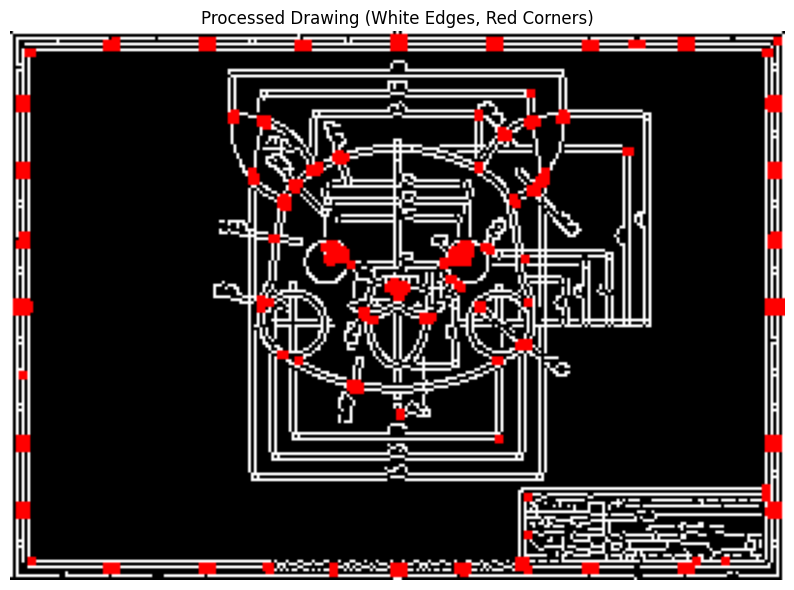

Success -  DXF saved as: digitized_cad_output.dxf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 PROCESS COMPLETE 
The vectorized DXF file should be downloading to your local machine now.
Look for the file: digitized_cad_output.dxf


In [ ]:
import cv2
import numpy as np
import ezdxf
import os
import matplotlib.pyplot as plt
from google.colab import files

#  DXF EXPORT HELPER FUNCTION
def export_lines_to_dxf(lines_data, image_height, output_path):
    """Converts the detected line coordinates into a DXF file."""
    doc = ezdxf.new(dxfversion='R2018')
    msp = doc.modelspace()

    # Simple Text Annotation
    msp.add_text("Digitized via Canny/Hough CV",
                 dxfattribs={'height': 10}).set_placement((10, 10))

    # Check if lines_data is None OR if it is a numpy array with zero length.
    if lines_data is None or (isinstance(lines_data, np.ndarray) and lines_data.size == 0):
        print("No lines to export.")
        doc.saveas(output_path)
        return

    # Invert Y-coordinates for CAD format (Y starts bottom-up)
    for line in lines_data:
        x1, y1, x2, y2 = line[0]
        # Inverting Y-axis for CAD system
        msp.add_line((x1, image_height - y1), (x2, image_height - y2),
                     dxfattribs={'layer': 'OBJECT_LINE', 'color': 7}) # Color 7 is white/black

    try:
        doc.saveas(output_path)
        print(f"Success -  DXF saved as: {output_path}")
    except Exception as e:
        print(f"Error saving DXF: {e}")

#  MAIN IMAGE PROCESSING PIPELINE
def process_cad_image_colab(image_path, output_dxf_path):
    # Load image in color to draw corner markers later
    img_color = cv2.imread(image_path)

    if img_color is None:
        print(f"Error: Could not load image at {image_path}")
        return

    height, width, _ = img_color.shape

    # 1. PREPROCESSING: Convert to Grayscale and Float32
    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    gray_float = np.float32(gray)

    # 2. CANNY EDGE DETECTION (The line skeletonizer)
    canny_edges = cv2.Canny(gray, 50, 150)
    print("Canny Edge Detection Complete.")

    # 3. HARRIS CORNER DETECTION (Finding vertices/endpoints)
    harris_dst = cv2.cornerHarris(gray_float, blockSize=2, ksize=3, k=0.04)
    harris_dst = cv2.dilate(harris_dst, None)

    # Create the visualization image (BGR -> RGB conversion for Matplotlib)
    corners_vis = cv2.cvtColor(img_color.copy(), cv2.COLOR_BGR2RGB)

    # Thresholding: pixels above 0.01 * max(response) are marked as corners (RED)
    # Harris returns a floating-point response; we mark the strong corners
    corners_vis[harris_dst > 0.01 * harris_dst.max()] = [255, 0, 0] # RGB color: Red
    print("Harris Corner Detection Complete.")

    #  VISUALIZATION OUTPUT
    # Combine Canny output (white edges on black) with Harris corners (Red dots)
    output_combined_vis = cv2.cvtColor(canny_edges, cv2.COLOR_GRAY2BGR)
    output_combined_vis[harris_dst > 0.01 * harris_dst.max()] = [0, 0, 255] # BGR Red

    # Display the visualization image in the Colab cell
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output_combined_vis, cv2.COLOR_BGR2RGB))
    plt.title("Processed Drawing (White Edges, Red Corners)")
    plt.axis('off')
    plt.show()

    # 4. HOUGH LINE TRANSFORM (Vectorization from Canny edges)
    lines = cv2.HoughLinesP(canny_edges, rho=1, theta=np.pi/180, threshold=80,
                            minLineLength=30, maxLineGap=10)

    if lines is None:
        print("No vector lines detected by Hough Transform.")
        lines = []

    # 5. DXF EXPORT
    export_lines_to_dxf(lines, height, output_dxf_path)

    # 6. DOWNLOAD DXF FILE (Specific to Colab)
    try:
        files.download(output_dxf_path)
    except Exception as e:
        print(f"Error during file download: {e}")


# --- EXECUTION FOR COLAB ---
if __name__ == "__main__":
    # --- STEP 1: UPLOAD FILE ---
    print("Please upload your manual CAD drawing image:")
    # This will open a file selection dialog in Colab
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Exiting script.")
    else:
        # Get the name of the uploaded file
        uploaded_filename = list(uploaded.keys())[0]

        OUTPUT_DXF = "digitized_cad_output.dxf"

        # --- STEP 2: PROCESS AND EXPORT ---
        process_cad_image_colab(uploaded_filename, OUTPUT_DXF)
        print("\n PROCESS COMPLETE ")
        print("The vectorized DXF file should be downloading to your local machine now.")
        print(f"Look for the file: {OUTPUT_DXF}")

In [ ]:
!pip install ezdxf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.3 MB/s eta 0:00:00
